In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lib.utils import train_nn_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pysr import PySRRegressor

/home/hien/Work/AI/SDS-CP032-mlpaygrade/.venv/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [ ]:
cwd = Path.cwd()
source_data = Path(cwd)/"data"
output = Path(cwd)/"output"
preprocessed_data = cwd/'output/preprocessed_data'

# Loading Dataset

In [3]:
salaries = pd.read_parquet(preprocessed_data/'preprocessed_data.parquet')
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16494 entries, 0 to 16493
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   experience_level      16494 non-null  object 
 1   company_size          16494 non-null  object 
 2   work_year             16494 non-null  object 
 3   remote_ratio          16494 non-null  object 
 4   salary_currency       16494 non-null  object 
 5   employment_type       16494 non-null  object 
 6   job_type              16494 non-null  object 
 7   employee_continent    16494 non-null  object 
 8   company_continent     16494 non-null  object 
 9   job_level             16494 non-null  object 
 10  exp_level_job         16494 non-null  object 
 11  exp_level_econtinent  16494 non-null  object 
 12  job_level_exp         16494 non-null  object 
 13  work_year_econtinent  16494 non-null  object 
 14  kmeans_group          16494 non-null  object 
 15  same_continent     

In [4]:
X_train = np.load(preprocessed_data/'preprocessed_X_train.npy')
y_train = np.load(preprocessed_data/'preprocessed_y_train.npy')
X_test = np.load(preprocessed_data/'preprocessed_X_test.npy')
y_test = np.load(preprocessed_data/'preprocessed_y_test.npy')

# Deep Learning

In [5]:
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [6]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)  # ensures shape (N, 1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch [1/100], Train Loss: 13.9620, Test Loss: 0.6532
Epoch [2/100], Train Loss: 3.6056, Test Loss: 0.6198
Epoch [3/100], Train Loss: 3.2712, Test Loss: 0.3510
Epoch [4/100], Train Loss: 3.0662, Test Loss: 0.3522
Epoch [5/100], Train Loss: 2.9762, Test Loss: 0.5212
Epoch [6/100], Train Loss: 2.8925, Test Loss: 0.3101
Epoch [7/100], Train Loss: 2.6820, Test Loss: 0.2799
Epoch [8/100], Train Loss: 2.5792, Test Loss: 0.3139
Epoch [9/100], Train Loss: 2.4171, Test Loss: 0.2489
Epoch [10/100], Train Loss: 2.3041, Test Loss: 0.1983
Epoch [11/100], Train Loss: 2.1383, Test Loss: 0.3465
Epoch [12/100], Train Loss: 2.0757, Test Loss: 0.2099
Epoch [13/100], Train Loss: 1.9461, Test Loss: 0.1731
Epoch [14/100], Train Loss: 1.7751, Test Loss: 0.1604
Epoch [15/100], Train Loss: 1.6793, Test Loss: 0.2094
Epoch [16/100], Train Loss: 1.5736, Test Loss: 0.1792
Epoch [17/100], Train Loss: 1.4936, Test Loss: 0.2432
Epoch [18/100], Train Loss: 1.4242, Test Loss: 0.1431
Epoch [19/100], Train Loss: 1.3333, 

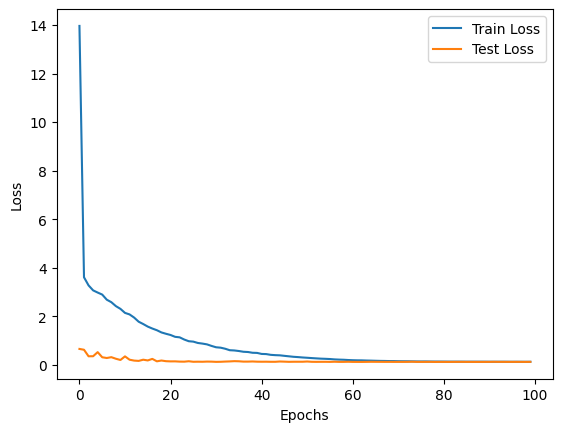

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ANNModel(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses = train_nn_model(model, train_loader, test_loader,
                                       criterion, optimizer, device, num_epochs=100)

plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Symbolic Regression

In [ ]:
pysr_model = PySRRegressor(
    model_selection='accuracy',
    niterations=1,  # Adjust this based on needs
    binary_operators=['+', '*', '-', '/'],
    unary_operators=['cos', 'exp', 'sin', 'log'],
    loss="loss(x, y) = (x - y)^2",  # MSE loss,,
    populations=300, # Adjust this based on needs,
    population_size=500, # Adjust this based on needs,
    ncyclesperiteration=1000,
    maxsize=200, # Adjust this based on needs
    batching=True,
    nested_constraints={"sin": {"sin": 0, "cos": 0}, "cos": {"sin": 0, "cos": 0}},
    parsimony=0.20,
    bumper=True,
    verbosity=0,
    progress=False,
    procs=100,
    output_directory=output/'pysr_outputs'
)

pysr_model.fit(X_train, y_train)

In [ ]:
symbolic_eq = pysr_model.get_best()
best_equation = pysr_model.sympy()
y_pred = pysr_model.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", root_mean_squared_error(y_test, y_pred))
print("Test R2:", r2_score(y_test, y_pred))
print("Best equation:", best_equation)


Best equation: cos(x107*x54)*cos(x107*x141*x40 + 0.169984640067597) + 10.97349235
Test MSE: 0.14757214478730887
Test RMSE: 0.3841512004241414
Test R2: 0.3399615639356529


In [ ]:
symbolic_eq

In [ ]:
sr_training_loss = pysr_model.equations_
sr_training_loss.plot(x="complexity", y="loss")

AttributeError: 'ANNModel' object has no attribute 'equations_'